# Semi-Supervised Learning Models

In [4]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('fivethirtyeight')
import seaborn as sns
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',35)

import warnings
warnings.filterwarnings('ignore')

import itertools, math, time, re, pickle

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, ShuffleSplit
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, auc, confusion_matrix, precision_score, recall_score, roc_curve, f1_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize, LabelBinarizer
from sklearn.svm import SVC
from xgboost import XGBClassifier

import keras
from keras.models import Sequential
from keras.layers import Dense

# Modeling Prep

## Load Data

In [2]:
# prelabeled set used for initial training
prelabeled_df = pd.read_csv('data/finalized_data/training')

# unlabeled set used for predictions after initial training
unlabeled_df = pd.read_csv('data/finalized_data/unlabeled')

In [3]:
prelabeled_df.head()

Player    GP   MIN   PTS   FGA   FG%  3PA    3P%   REB  AST  \
0    Aaron Gordon: 2015  78.0  23.9   9.2   7.4  47.3  1.8   29.6   6.5  1.6   
1      Al Horford: 2015  82.0  32.1  15.2  12.8  50.5  3.1   34.4   7.3  3.2   
2    Al Jefferson: 2015  47.0  23.3  12.0  10.7  48.5  0.0    0.0   6.4  1.5   
3  Andre Drummond: 2015  81.0  32.9  16.2  13.1  52.1  0.1   33.3  14.8  0.8   
4    Andrew Bogut: 2015  70.0  20.7   5.4   4.0  62.7  0.0  100.0   7.0  2.3   

    TO  STL  BLK  Close FGA  Close FG%  Mid FGA  Mid FG%  Post_Ups  Drives  \
0  0.8  0.8  0.7        4.3       60.5      1.3     31.7       0.6     2.2   
1  1.3  0.8  1.5        5.6       64.3      4.1     44.4       3.8     2.1   
2  0.7  0.6  0.9        6.8       51.5      4.0     43.9      11.3     0.0   
3  1.9  1.5  1.4       12.2       54.1      0.8     25.0       6.0     0.9   
4  1.2  0.5  1.6        3.8       65.8      0.1     30.0       2.5     0.1   

   CS_3PA  CS_3P%  PP100Pos  AST %  REB %  USG %  Height Pos  Class TEAM  
0     1.7    30.5      18.9   10.3   13.3   16.9    81.0  PF    7.0  ORL  
1     3.0    35.1      22.9   16.5   10.9   20.2    82.0   C    3.0  ATL  
2     0.0     0.0      25.3   11.4   13.3   24.0    82.0   C    2.0  CHA  
3     0.0     0.0      24.6    4.2   21.7   23.9    83.0   C    2.0  DET  
4     0.0     0.0      12.4   14.5   16.3   11.5    84.0   C    2.0  GSW

To prevent class imbalances, I tried to get at least 30 and less than 40 players of each class.

In [4]:
prelabeled_df['Class'].value_counts()

5.0     36
7.0     34
4.0     33
1.0     33
2.0     33
10.0    32
3.0     31
11.0    30
8.0     30
9.0     30
6.0     30
Name: Class, dtype: int64

In [5]:
unlabeled_df.head()

Player    GP   MIN   PTS   FGA   FG%  3PA   3P%  REB  AST  \
0  Al-Farouq Aminu: 2015  82.0  28.5  10.2   8.8  41.6  4.3  36.1  6.1  1.7   
1       Alec Burks: 2015  31.0  25.7  13.3  10.8  41.0  2.5  40.5  3.5  2.0   
2         Alex Len: 2015  78.0  23.3   9.0   8.0  42.3  0.1  14.3  7.6  1.2   
3     Allen Crabbe: 2015  81.0  26.0  10.3   8.4  45.9  3.5  39.3  2.7  1.2   
4       Alonzo Gee: 2015  73.0  22.4   4.5   3.5  51.8  0.8  28.3  3.4  1.0   

    TO  STL  BLK  Close FGA  Close FG%  Mid FGA  Mid FG%  Post_Ups  Drives  \
0  1.5  0.9  0.6        3.4       50.0      1.1     37.6       0.4     3.5   
1  1.6  0.6  0.1        5.1       47.1      3.1     32.3       0.0     8.0   
2  1.9  0.5  0.8        5.4       46.3      2.5     32.6       5.0     0.6   
3  0.8  0.8  0.2        1.7       58.8      3.1     44.8       0.1     1.8   
4  0.8  0.9  0.2        2.3       65.2      0.4     25.0       0.1     1.5   

   CS_3PA  CS_3P%  PP100Pos  AST %  REB %  USG %  Height Pos  Class TEAM  
0     4.0    36.3      17.5    8.7   10.4   16.6    81.0  SF    NaN  POR  
1     1.5    40.4      26.1   14.0    6.9   24.6    78.0  SG    NaN  UTA  
2     0.1    16.7      18.6    8.7   15.6   20.2    85.0   C    NaN  PHX  
3     3.2    41.1      19.2    7.2    4.9   15.9    78.0  SG    NaN  POR  
4     0.7    30.2       9.7    6.3    7.3    9.1    78.0  SF    NaN  NOP

## Model Functions & Metrics

**Build Model Function**

In [6]:
def build_model(model, X_train, X_test, y_train, y_test, decision_function=True, n_classes=11):
    start = time.time()
    
    # make sure to uncomment the next line for logistic regression
    #clf = OneVsRestClassifier(model)
    
    # comment this next line for logistic regression
    clf = model
    clf.fit(X_train,y_train)  
    y_hat_test = clf.predict(X_test)
      
    if decision_function==True:
        y_score = clf.decision_function(X_test)
    else:
        y_score = clf.predict_proba(X_test)[:, 1]
        
    print('Total Runtime: {} seconds'.format(time.time()-start))
    
    return clf, y_hat_test, y_score

**Plot Feature Importances** 

In [7]:
def plot_feature_importances(model):
    n_features = len(X.columns)
    plt.figure(figsize=(14,10))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X.columns.values) 
    plt.xlabel("Feature importance")
    plt.ylabel("Features")

**Plot Confusion Matrix**

In [8]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    #Create the basic matrix.
    plt.figure(figsize=(10,10))
    plt.imshow(cm, cmap)
    
    #Add title and Axis Labels
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    #Add appropriate Axis Scales
    class_names = ['1','2', '3', '4', '5', '6', '7', '8', '9', '10', '11']
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    
    #Add Labels to Each Cell
    thresh = cm.max()*.75
    
    #Add a Side Bar Legend Showing Colors
    plt.colorbar()
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

**Plot Metrics**

In [10]:
def print_model_metrics(y_pred,y_score,y_test):
    cm = confusion_matrix(y_test, y_pred)
    #print(cm)

    plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues)

    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred, average='micro')
    recall = recall_score(y_test,y_pred, average='micro')
    f1 = f1_score(y_test,y_pred, average='micro')
    
    #print('Training Set Metrics:')
    print('Accuracy: {}\n'.format(round(accuracy,4)))
    print('Micro Precision: {}'.format(round(precision,4)))
    print('Micro Recall: {}'.format(round(recall,4)))
    print('Micro F1: {}\n'.format(round(f1,4)))

    print('Macro Precision: {:.4f}'.format(precision_score(y_test, y_pred, average='macro')))
    print('Macro Recall: {:.4f}'.format(recall_score(y_test, y_pred, average='macro')))
    print('Macro F1-score: {:.4f}\n'.format(f1_score(y_test, y_pred, average='macro')))

    print('Weighted Precision: {:.4f}'.format(precision_score(y_test, y_pred, average='weighted')))
    print('Weighted Recall: {:.4f}'.format(recall_score(y_test, y_pred, average='weighted')))
    print('Weighted F1-score: {:.4f}'.format(f1_score(y_test, y_pred, average='weighted')))

## Categorical Variables

In [11]:
X = prelabeled_df.drop(['Player', 'GP', 'Class', 'TEAM'], axis=1)
y = prelabeled_df['Class']

In [12]:
# get dummy variables for position
X = pd.get_dummies(X)
X.head()

MIN   PTS   FGA   FG%  3PA    3P%   REB  AST   TO  STL  BLK  Close FGA  \
0  23.9   9.2   7.4  47.3  1.8   29.6   6.5  1.6  0.8  0.8  0.7        4.3   
1  32.1  15.2  12.8  50.5  3.1   34.4   7.3  3.2  1.3  0.8  1.5        5.6   
2  23.3  12.0  10.7  48.5  0.0    0.0   6.4  1.5  0.7  0.6  0.9        6.8   
3  32.9  16.2  13.1  52.1  0.1   33.3  14.8  0.8  1.9  1.5  1.4       12.2   
4  20.7   5.4   4.0  62.7  0.0  100.0   7.0  2.3  1.2  0.5  1.6        3.8   

   Close FG%  Mid FGA  Mid FG%  Post_Ups  Drives  CS_3PA  CS_3P%  PP100Pos  \
0       60.5      1.3     31.7       0.6     2.2     1.7    30.5      18.9   
1       64.3      4.1     44.4       3.8     2.1     3.0    35.1      22.9   
2       51.5      4.0     43.9      11.3     0.0     0.0     0.0      25.3   
3       54.1      0.8     25.0       6.0     0.9     0.0     0.0      24.6   
4       65.8      0.1     30.0       2.5     0.1     0.0     0.0      12.4   

   AST %  REB %  USG %  Height  Pos_C  Pos_PF  Pos_PG  Pos_SF  Pos_SG  
0   10.3   13.3   16.9    81.0      0       1       0       0       0  
1   16.5   10.9   20.2    82.0      1       0       0       0       0  
2   11.4   13.3   24.0    82.0      1       0       0       0       0  
3    4.2   21.7   23.9    83.0      1       0       0       0       0  
4   14.5   16.3   11.5    84.0      1       0       0       0       0

## Train Test Split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=17)

In [14]:
y_train

153    11.0
94      2.0
108     6.0
109    11.0
155     9.0
       ... 
240    11.0
313     6.0
143     3.0
241     2.0
111     1.0
Name: Class, Length: 264, dtype: float64

In [15]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)

## Scale Data
Scaling is done after the train test split in order to ensure that the training set is not influenced at all by the test set.

In [16]:
# scale using MinMaxScaler
mm = MinMaxScaler()
X_train_scaled = mm.fit_transform(X_train)
X_test_scaled = mm.fit_transform(X_test)

# convert back into DataFrame to preserve column names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

In [17]:
X_train_scaled.head()

MIN       PTS       FGA       FG%       3PA    3P%       REB  \
0  0.522222  0.409639  0.544186  0.297059  0.272727  0.314  0.616667   
1  0.616667  0.237952  0.241860  0.602941  0.000000  0.000  0.716667   
2  0.900000  0.445783  0.600000  0.188235  0.310606  0.331  0.216667   
3  0.905556  0.759036  0.767442  0.470588  0.166667  0.340  0.775000   
4  0.916667  0.572289  0.651163  0.164706  0.583333  0.401  0.325000   

        AST        TO       STL       BLK  Close FGA  Close FG%   Mid FGA  \
0  0.277228  0.340426  0.388889  0.379310   0.534884   0.623377  0.366337   
1  0.089109  0.255319  0.111111  0.241379   0.488372   0.716883  0.128713   
2  0.138614  0.297872  0.444444  0.206897   0.503876   0.633766  0.455446   
3  0.168317  0.404255  0.666667  0.896552   0.875969   0.815584  0.534653   
4  0.267327  0.510638  0.944444  0.172414   0.372093   0.529870  0.376238   

    Mid FG%  Post_Ups    Drives    CS_3PA  CS_3P%  PP100Pos     AST %  \
0  0.646177  0.438849  0.120192  0.472973   0.320  0.468447  0.328261   
1  0.613193  0.223022  0.004808  0.000000   0.000  0.237864  0.069565   
2  0.476762  0.179856  0.370192  0.418919   0.349  0.412621  0.102174   
3  0.545727  0.460432  0.197115  0.256757   0.331  0.706311  0.154348   
4  0.497751  0.071942  0.427885  0.716216   0.410  0.533981  0.239130   

      REB %     USG %  Height  Pos_C  Pos_PF  Pos_PG  Pos_SF  Pos_SG  
0  0.638743  0.518395  0.8125    1.0     0.0     0.0     0.0     0.0  
1  0.717277  0.163880  0.7500    1.0     0.0     0.0     0.0     0.0  
2  0.157068  0.438127  0.5625    0.0     0.0     0.0     1.0     0.0  
3  0.602094  0.648829  0.6875    0.0     1.0     0.0     0.0     0.0  
4  0.235602  0.505017  0.6250    0.0     0.0     0.0     1.0     0.0

# Stage 1 Modeling

Modeling is done on the prelabeled data for this stage. The model created will be used to make predictions on the non-labeled data. In Stage 2, that newly labeled data will be used to create a new model.

## Random Forest

In [18]:
# tried scaled data as well, but better results achieved with non-scaled data
rf, rf_y_preds, rf_y_score = build_model(RandomForestClassifier(),
                                                         X_train, X_test,
                                                         y_train, y_test,
                                                        decision_function=False)

Total Runtime: 0.2262871265411377 seconds


Accuracy: 0.75

Micro Precision: 0.75
Micro Recall: 0.75
Micro F1: 0.75

Macro Precision: 0.7620
Macro Recall: 0.7663
Macro F1-score: 0.7551

Weighted Precision: 0.7665
Weighted Recall: 0.7500
Weighted F1-score: 0.7495


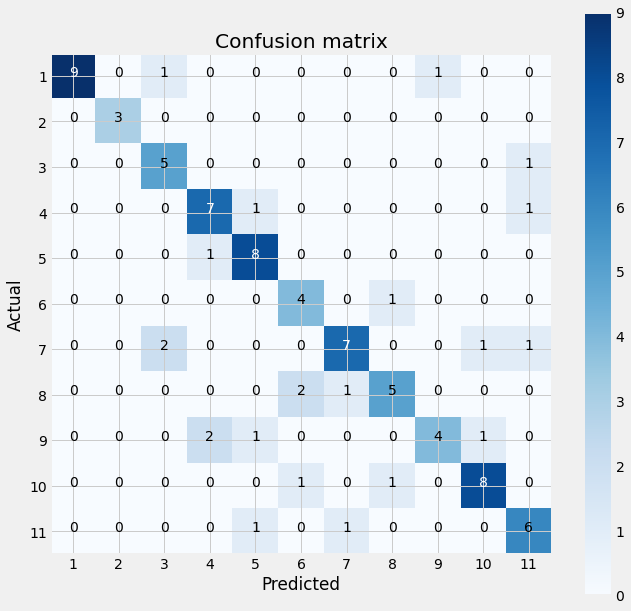

In [19]:
print_model_metrics(rf_y_preds, rf_y_score, y_test)

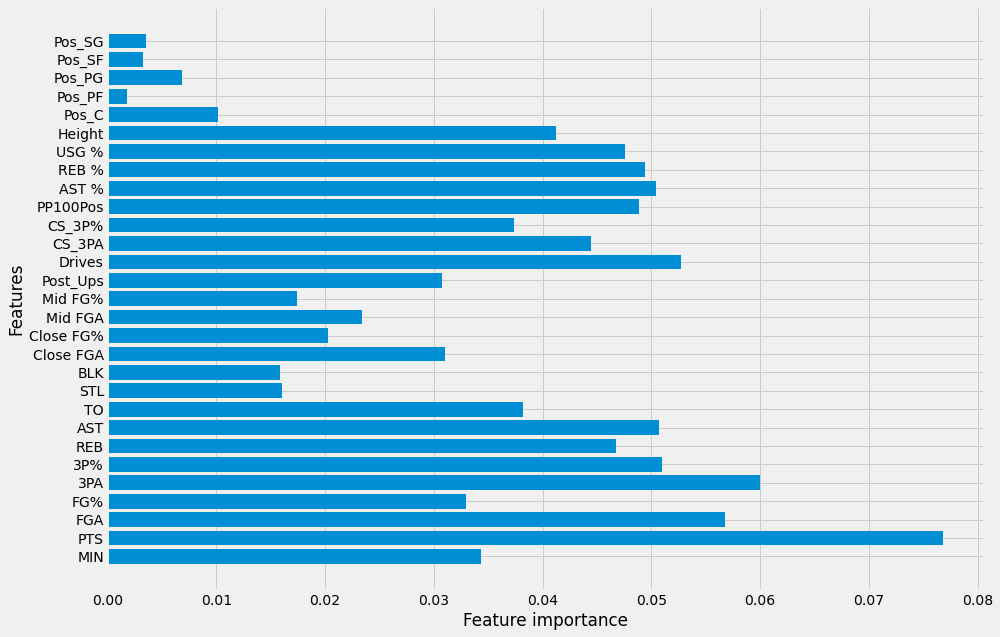

In [20]:
plot_feature_importances(rf)

**Gridsearch**

In [21]:
rf_param_grid = {"n_estimators": [100, 200, 300],
                  "min_samples_leaf": [3, 5],
                  "min_samples_split": [5,10,15],
                  "criterion": ["gini", "entropy"]
                }

In [22]:
rf_gs, rf_gs_y_preds, rf_gs_y_score = build_model(GridSearchCV(rf, param_grid=rf_param_grid),
                                                         X_train, X_test,
                                                         y_train, y_test,
                                                        decision_function=False)

Total Runtime: 49.46545910835266 seconds


Accuracy: 0.6932

Micro Precision: 0.6932
Micro Recall: 0.6932
Micro F1: 0.6932

Macro Precision: 0.7079
Macro Recall: 0.7139
Macro F1-score: 0.6963

Weighted Precision: 0.7035
Weighted Recall: 0.6932
Weighted F1-score: 0.6840


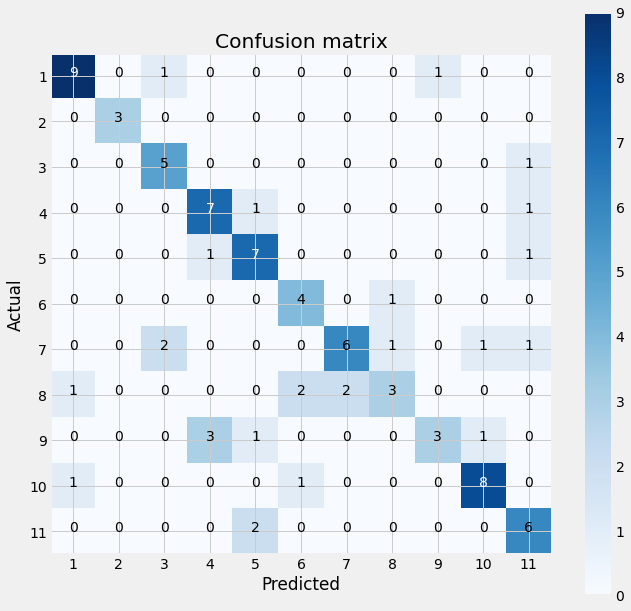

In [23]:
print_model_metrics(rf_gs_y_preds, rf_gs_y_score, y_test)

In [24]:
rf_gs.best_params_

{'criterion': 'entropy',
 'min_samples_leaf': 3,
 'min_samples_split': 5,
 'n_estimators': 100}

In [25]:
rf_gs.best_score_

0.7386066763425254

In [26]:
print(f'Training Accuracy: {rf_gs.score(X_train, y_train)}')
print(f'Test Accuracy: {rf_gs.score(X_test, y_test)}')

Training Accuracy: 0.9734848484848485
Test Accuracy: 0.6931818181818182


## Gradient Boost

In [27]:
gb, gb_y_preds, gb_y_score = build_model(GradientBoostingClassifier(),
                                         X_train, X_test, y_train, y_test)

Total Runtime: 1.847008228302002 seconds


Accuracy: 0.6932

Micro Precision: 0.6932
Micro Recall: 0.6932
Micro F1: 0.6932

Macro Precision: 0.6945
Macro Recall: 0.6879
Macro F1-score: 0.6850

Weighted Precision: 0.7190
Weighted Recall: 0.6932
Weighted F1-score: 0.6996


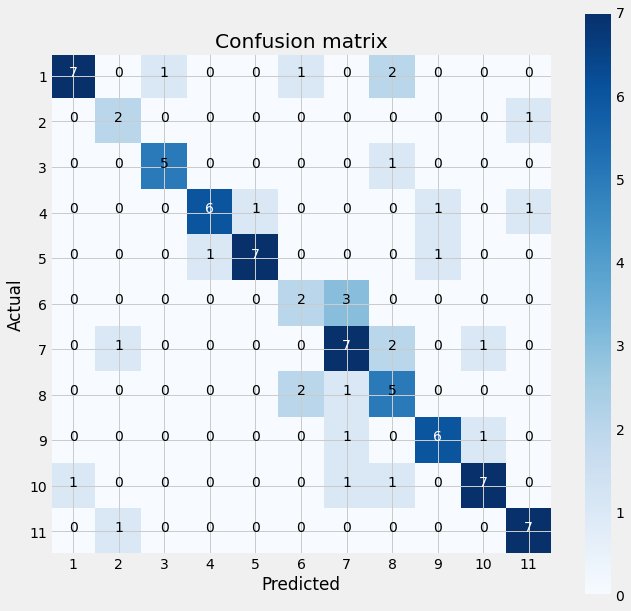

In [28]:
print_model_metrics(gb_y_preds, gb_y_score, y_test)

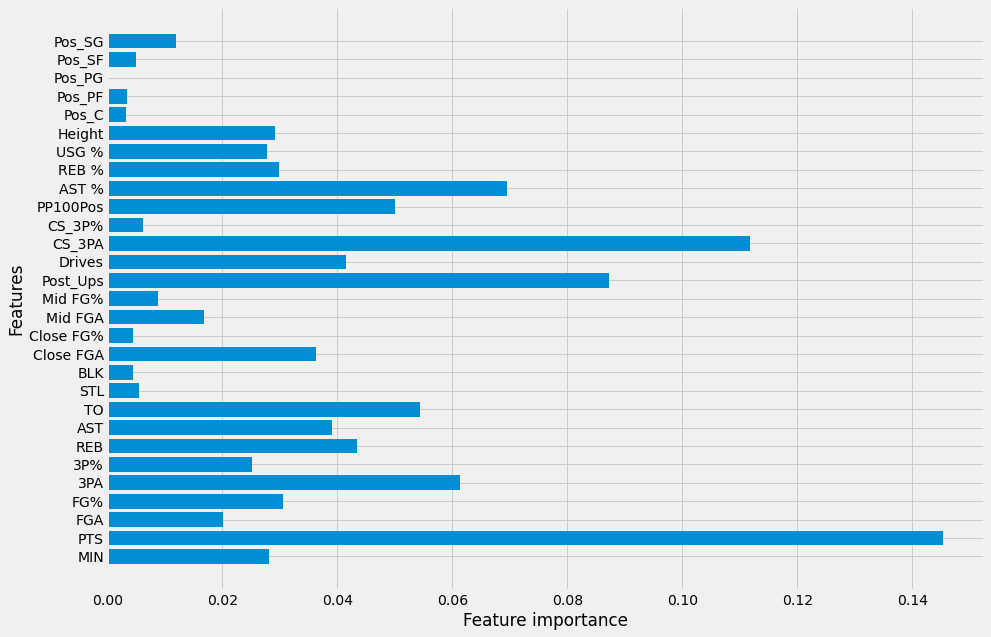

In [29]:
plot_feature_importances(gb)

**Gridsearch**

In [30]:
gb_param_grid = {"n_estimators": [50, 100, 250],
                  "learning_rate": [.005, .01, .1]
                }

gb_gs, gb_gs_y_preds, gb_gs_y_score = build_model(GridSearchCV(gb, param_grid=gb_param_grid),
                                                         X_train, X_test,
                                                         y_train, y_test,
                                                        decision_function=False)

Total Runtime: 84.05776619911194 seconds


Accuracy: 0.6818

Micro Precision: 0.6818
Micro Recall: 0.6818
Micro F1: 0.6818

Macro Precision: 0.7155
Macro Recall: 0.7017
Macro F1-score: 0.7022

Weighted Precision: 0.7100
Weighted Recall: 0.6818
Weighted F1-score: 0.6888


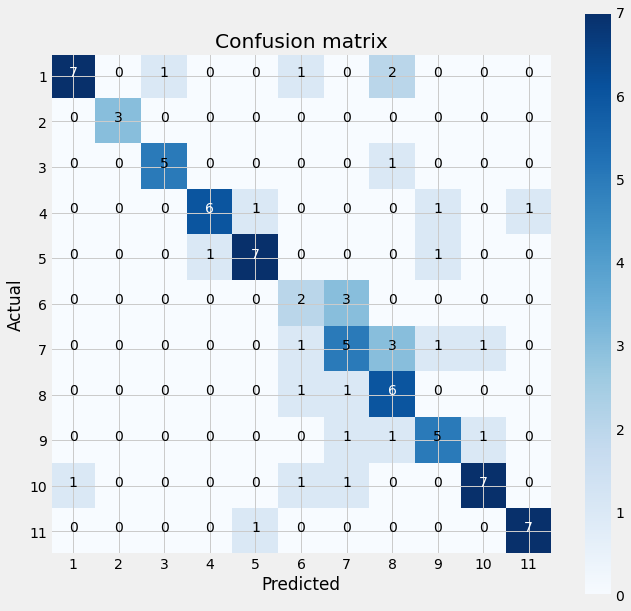

In [31]:
print_model_metrics(gb_gs_y_preds, gb_gs_y_score, y_test)

In [32]:
print(gb_gs.best_params_)

print(f'Training Accuracy: {gb_gs.score(X_train, y_train)}')
print(f'Test Accuracy: {gb_gs.score(X_test, y_test)}')

{'learning_rate': 0.1, 'n_estimators': 250}
Training Accuracy: 1.0
Test Accuracy: 0.6818181818181818


## AdaBoost

In [33]:
ada, ada_y_preds, ada_y_score = build_model(AdaBoostClassifier(algorithm="SAMME",
                                                              learning_rate=.05),
                                            X_train, X_test, y_train, y_test)

Total Runtime: 0.14018607139587402 seconds


Accuracy: 0.2955

Micro Precision: 0.2955
Micro Recall: 0.2955
Micro F1: 0.2955

Macro Precision: 0.2267
Macro Recall: 0.3788
Macro F1-score: 0.2430

Weighted Precision: 0.2171
Weighted Recall: 0.2955
Weighted F1-score: 0.2247


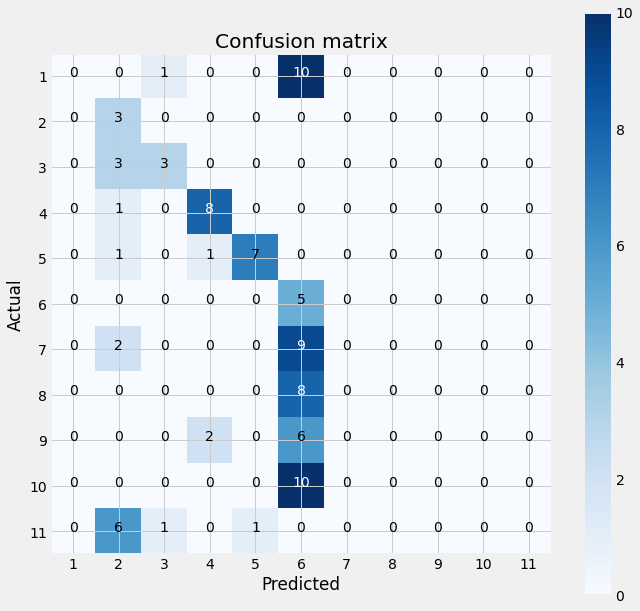

In [34]:
print_model_metrics(ada_y_preds, ada_y_score, y_test)

## XGBoost

In [35]:
xgb, xgb_y_preds, xgb_y_score = build_model(XGBClassifier(objective='multi:softmax'), 
                                            X_train, X_test, y_train, y_test, decision_function=False)

Total Runtime: 0.219404935836792 seconds


Accuracy: 0.7614

Micro Precision: 0.7614
Micro Recall: 0.7614
Micro F1: 0.7614

Macro Precision: 0.7703
Macro Recall: 0.7716
Macro F1-score: 0.7574

Weighted Precision: 0.7837
Weighted Recall: 0.7614
Weighted F1-score: 0.7604


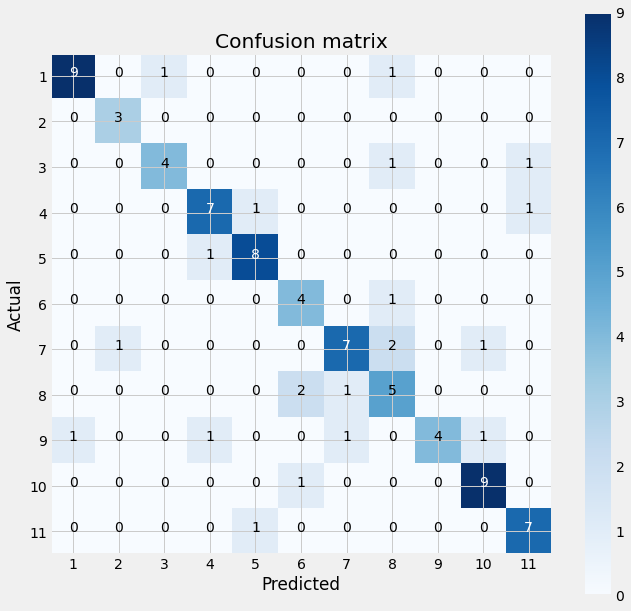

In [36]:
print_model_metrics(xgb_y_preds, xgb_y_score, y_test)

In [37]:
xgb_param_grid = {"min_child_weight": [1, 2],
                  "max_depth": [3, 6, 9],
                  "eta": [.01, .05, .3]
                }

xgb_gs, xgb_gs_y_preds, xgb_gs_y_score = build_model(GridSearchCV(xgb, param_grid=xgb_param_grid),
                                                         X_train, X_test,
                                                         y_train, y_test,
                                                        decision_function=False)

Total Runtime: 17.45914101600647 seconds


Accuracy: 0.75

Micro Precision: 0.75
Micro Recall: 0.75
Micro F1: 0.75

Macro Precision: 0.7654
Macro Recall: 0.7595
Macro F1-score: 0.7489

Weighted Precision: 0.7851
Weighted Recall: 0.7500
Weighted F1-score: 0.7548


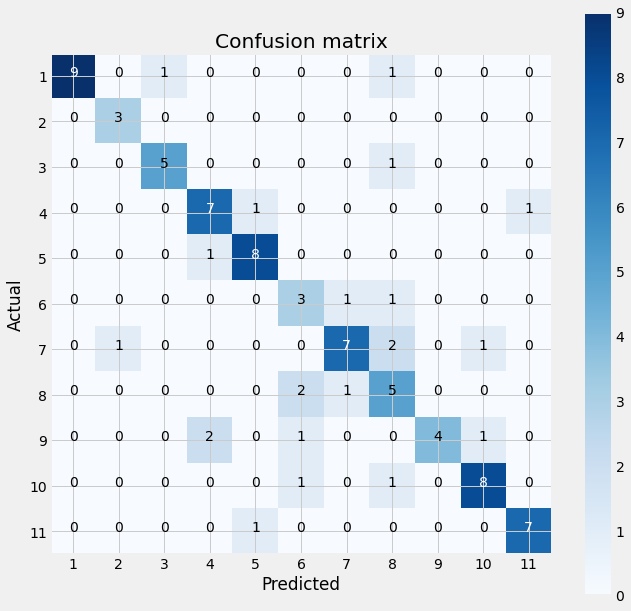

In [39]:
print_model_metrics(xgb_gs_y_preds, xgb_gs_y_score, y_test)

In [40]:
xgb_gs.best_params_

{'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1}

## SVM: Support Vector Machine

In [41]:
svm, svm_y_preds, svm_y_score = build_model(SVC(decision_function_shape='ovo'), 
                                            X_train, X_test, y_train, y_test)

Total Runtime: 0.03778696060180664 seconds


Accuracy: 0.4545

Micro Precision: 0.4545
Micro Recall: 0.4545
Micro F1: 0.4545

Macro Precision: 0.4095
Macro Recall: 0.5161
Macro F1-score: 0.4090

Weighted Precision: 0.3778
Weighted Recall: 0.4545
Weighted F1-score: 0.3713


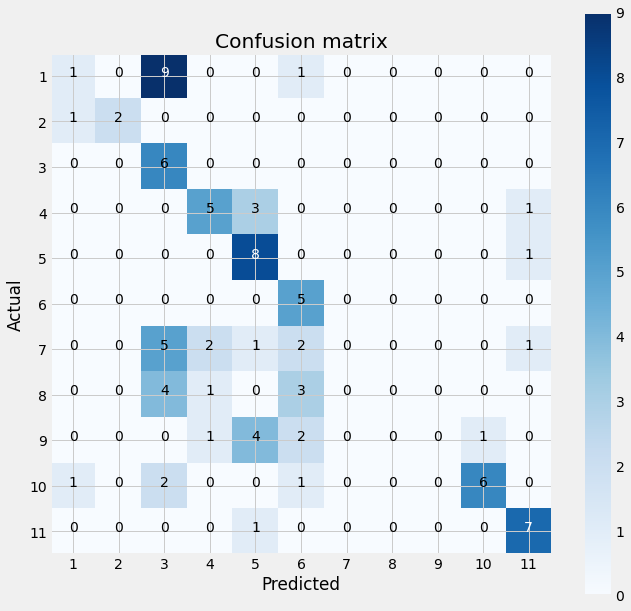

In [43]:
print_model_metrics(svm_y_preds, svm_y_score, y_test)

# Stage 2 Modeling

This stage will create predictions from the previous model on the non-labeled data. Afterwards, the predictions will be used to train a new model.

The best model from the previous stage was the XGBoost.

## Data Preparation

In [44]:
# make predictions

pred_set = unlabeled_df.drop(['Player', 'GP', 'Class', 'TEAM'], axis=1)
pred_set = pd.get_dummies(pred_set)
pred_set.head()

MIN   PTS   FGA   FG%  3PA   3P%  REB  AST   TO  STL  BLK  Close FGA  \
0  28.5  10.2   8.8  41.6  4.3  36.1  6.1  1.7  1.5  0.9  0.6        3.4   
1  25.7  13.3  10.8  41.0  2.5  40.5  3.5  2.0  1.6  0.6  0.1        5.1   
2  23.3   9.0   8.0  42.3  0.1  14.3  7.6  1.2  1.9  0.5  0.8        5.4   
3  26.0  10.3   8.4  45.9  3.5  39.3  2.7  1.2  0.8  0.8  0.2        1.7   
4  22.4   4.5   3.5  51.8  0.8  28.3  3.4  1.0  0.8  0.9  0.2        2.3   

   Close FG%  Mid FGA  Mid FG%  Post_Ups  Drives  CS_3PA  CS_3P%  PP100Pos  \
0       50.0      1.1     37.6       0.4     3.5     4.0    36.3      17.5   
1       47.1      3.1     32.3       0.0     8.0     1.5    40.4      26.1   
2       46.3      2.5     32.6       5.0     0.6     0.1    16.7      18.6   
3       58.8      3.1     44.8       0.1     1.8     3.2    41.1      19.2   
4       65.2      0.4     25.0       0.1     1.5     0.7    30.2       9.7   

   AST %  REB %  USG %  Height  Pos_C  Pos_PF  Pos_PG  Pos_SF  Pos_SG  
0    8.7   10.4   16.6    81.0      0       0       0       1       0  
1   14.0    6.9   24.6    78.0      0       0       0       0       1  
2    8.7   15.6   20.2    85.0      1       0       0       0       0  
3    7.2    4.9   15.9    78.0      0       0       0       0       1  
4    6.3    7.3    9.1    78.0      0       0       0       1       0

In [45]:
unlabeled_df['Class'] = xgb.predict(pred_set)
unlabeled_df

Player    GP   MIN   PTS   FGA   FG%  3PA   3P%  REB  \
0       Al-Farouq Aminu: 2015  82.0  28.5  10.2   8.8  41.6  4.3  36.1  6.1   
1            Alec Burks: 2015  31.0  25.7  13.3  10.8  41.0  2.5  40.5  3.5   
2              Alex Len: 2015  78.0  23.3   9.0   8.0  42.3  0.1  14.3  7.6   
3          Allen Crabbe: 2015  81.0  26.0  10.3   8.4  45.9  3.5  39.3  2.7   
4            Alonzo Gee: 2015  73.0  22.4   4.5   3.5  51.8  0.8  28.3  3.4   
...                       ...   ...   ...   ...   ...   ...  ...   ...  ...   
1026    Wayne Ellington: 2020  31.0  23.2  10.7   8.0  45.8  6.4  43.1  1.8   
1027  Wendell Carter Jr: 2020  32.0  24.7  10.9   7.9  51.2  0.7  36.4  7.8   
1028    Wesley Matthews: 2020  37.0  20.1   4.5   4.1  35.9  3.3  34.7  1.4   
1029        Will Barton: 2020  41.0  30.7  12.7  11.0  43.5  4.7  37.7  4.1   
1030        Zach LaVine: 2020  43.0  35.3  28.1  19.3  52.0  8.1  43.7  5.0   

      AST   TO  STL  BLK  Close FGA  Close FG%  Mid FGA  Mid FG%  Post_Ups  \
0     1.7  1.5  0.9  0.6        3.4       50.0      1.1     37.6       0.4   
1     2.0  1.6  0.6  0.1        5.1       47.1      3.1     32.3       0.0   
2     1.2  1.9  0.5  0.8        5.4       46.3      2.5     32.6       5.0   
3     1.2  0.8  0.8  0.2        1.7       58.8      3.1     44.8       0.1   
4     1.0  0.8  0.9  0.2        2.3       65.2      0.4     25.0       0.1   
...   ...  ...  ...  ...        ...        ...      ...      ...       ...   
1026  1.5  0.7  0.4  0.2        1.1       63.6      0.7     40.0       0.0   
1027  2.2  1.5  0.6  0.8        5.9       55.9      1.2     38.5       2.5   
1028  1.0  0.5  0.5  0.4        0.6       50.0      0.3     20.0       0.3   
1029  3.1  1.7  0.9  0.4        5.2       50.0      1.2     41.7       0.0   
1030  4.9  3.8  0.9  0.5        8.4       63.1      2.8     44.6       0.4   

      Drives  CS_3PA  CS_3P%  PP100Pos  AST %  REB %  USG %  Height Pos  \
0        3.5     4.0    36.3      17.5    8.7   10.4   16.6    81.0  SF   
1        8.0     1.5    40.4      26.1   14.0    6.9   24.6    78.0  SG   
2        0.6     0.1    16.7      18.6    8.7   15.6   20.2    85.0   C   
3        1.8     3.2    41.1      19.2    7.2    4.9   15.9    78.0  SG   
4        1.5     0.7    30.2       9.7    6.3    7.3    9.1    78.0  SF   
...      ...     ...     ...       ...    ...    ...    ...     ...  ..   
1026     1.9     4.0    41.6      22.4    9.4    3.9   16.8    76.0  SG   
1027     1.0     0.7    36.4      20.6   12.6   15.4   18.5    82.0   C   
1028     1.2     2.8    34.3      10.7    6.5    3.5   10.1    76.0  SG   
1029     6.1     2.9    39.2      20.1   13.2    6.8   19.0    78.0  SF   
1030    12.8     2.7    49.1      37.4   22.5    7.2   30.1    77.0  SG   

      Class TEAM  
0        10  POR  
1         6  UTA  
2         2  PHX  
3         1  POR  
4        10  NOP  
...     ...  ...  
1026      1  DET  
1027      2  ORL  
1028     10  LAL  
1029      8  DEN  
1030      5  CHI  

[1031 rows x 29 columns]

In [47]:
# combine prelabeled data and predictions into one dataset
new_labeled_df = pd.concat([prelabeled_df, unlabeled_df])

Now we need to make our X and y sets, along with a scaled version of X. Then, we split the data using train_test_split to get our training and testing sets.

In [48]:
X2 = new_labeled_df.drop(['Player', 'GP', 'Class', 'TEAM'], axis=1)
X2 = pd.get_dummies(X2)
y2 = new_labeled_df['Class']

In [49]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, random_state=17)

Create a scaled set as well to use.

In [50]:
y2_train = y2_train.astype(int)
y2_test = y2_test.astype(int)

# scale using MinMaxScaler
mm = MinMaxScaler()
X2_train_scaled = mm.fit_transform(X2_train)
X2_test_scaled = mm.fit_transform(X2_test)

# convert back into DataFrame to preserve column names
X2_train_scaled = pd.DataFrame(X2_train_scaled, columns=X2.columns)
X2_test_scaled = pd.DataFrame(X2_test_scaled, columns=X2.columns)

## Modeling

### Random Forest

In [57]:
# tried scaled data as well, but better results achieved with non-scaled data
rf2, rf2_y_preds, rf2_y_score = build_model(RandomForestClassifier(),
                                                         X2_train, X2_test,
                                                         y2_train, y2_test,
                                                        decision_function=False)

Total Runtime: 0.4183330535888672 seconds


Accuracy: 0.7746

Micro Precision: 0.7746
Micro Recall: 0.7746
Micro F1: 0.7746

Macro Precision: 0.7547
Macro Recall: 0.7585
Macro F1-score: 0.7457

Weighted Precision: 0.7747
Weighted Recall: 0.7746
Weighted F1-score: 0.7670


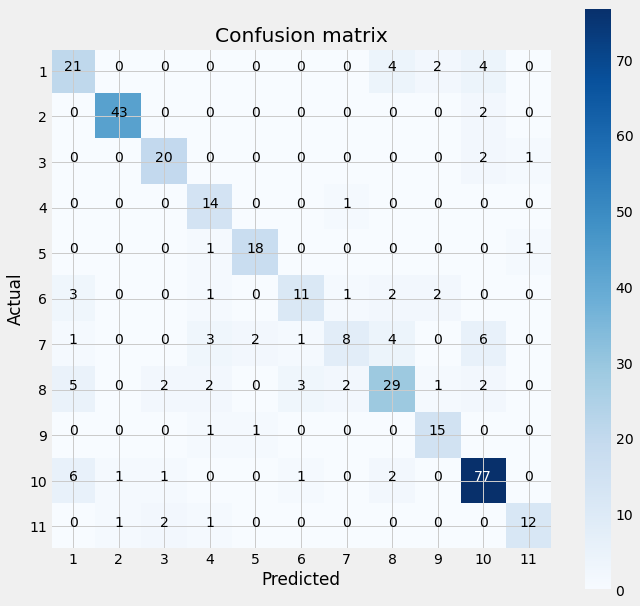

In [58]:
print_model_metrics(rf2_y_preds, rf2_y_score, y2_test)

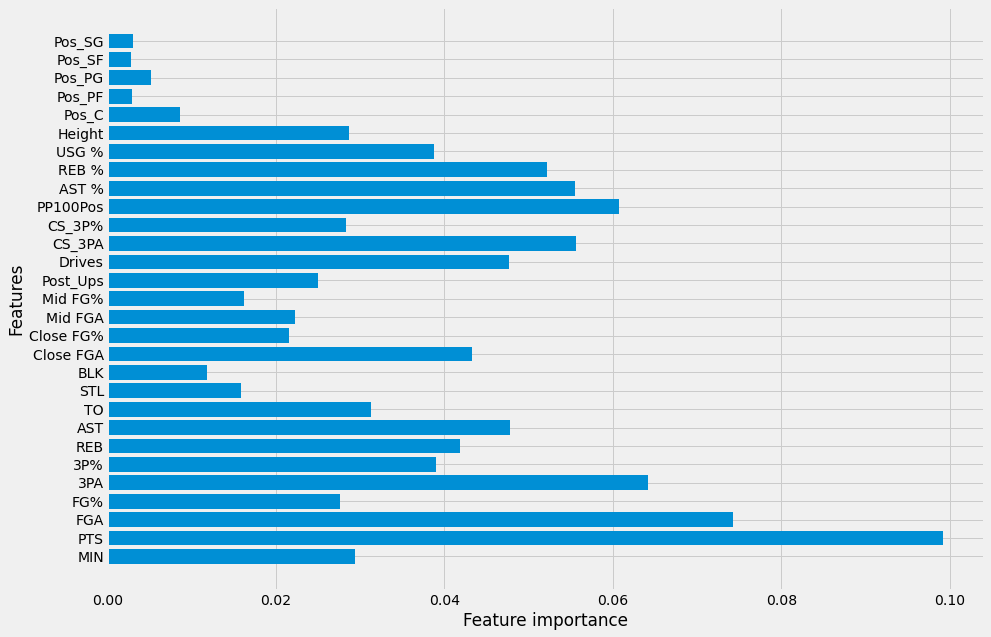

In [59]:
plot_feature_importances(rf2)

In [61]:
print(f'Training Accuracy: {rf2.score(X2_train, y2_train)}')
print(f'Test Accuracy: {rf2.score(X2_test, y2_test)}')

Training Accuracy: 1.0
Test Accuracy: 0.7745664739884393


**Gridsearch**

In [69]:
rf2_param_grid = {"min_samples_leaf": [1, 3, 5],
                  "min_samples_split": [2, 4, 6],
                  "criterion": ["gini", "entropy"],
                  "n_estimators": [100, 200, 300]
                }

In [70]:
rf2_gs, rf2_gs_y_preds, rf2_gs_y_score = build_model(GridSearchCV(rf2, param_grid=rf2_param_grid),
                                                         X2_train, X2_test,
                                                         y2_train, y2_test,
                                                        decision_function=False)

Total Runtime: 128.14771699905396 seconds


Accuracy: 0.7977

Micro Precision: 0.7977
Micro Recall: 0.7977
Micro F1: 0.7977

Macro Precision: 0.7848
Macro Recall: 0.7778
Macro F1-score: 0.7633

Weighted Precision: 0.8057
Weighted Recall: 0.7977
Weighted F1-score: 0.7893


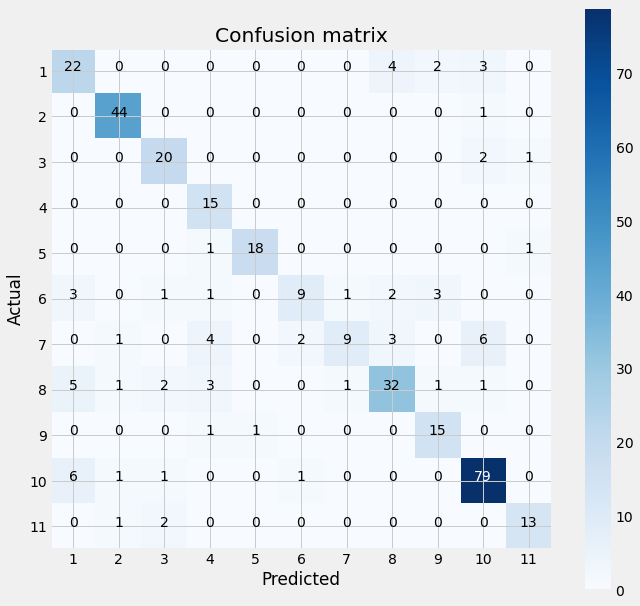

In [71]:
print_model_metrics(rf2_gs_y_preds, rf2_gs_y_score, y2_test)

In [72]:
print(rf2_gs.best_params_)

{'criterion': 'entropy', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


### Gradient Boost

In [54]:
gb2, gb2_y_preds, gb2_y_score = build_model(GradientBoostingClassifier(),
                                         X2_train, X2_test, y2_train, y2_test)

Total Runtime: 4.575927257537842 seconds


Accuracy: 0.8035

Micro Precision: 0.8035
Micro Recall: 0.8035
Micro F1: 0.8035

Macro Precision: 0.7832
Macro Recall: 0.7810
Macro F1-score: 0.7714

Weighted Precision: 0.8055
Weighted Recall: 0.8035
Weighted F1-score: 0.7969


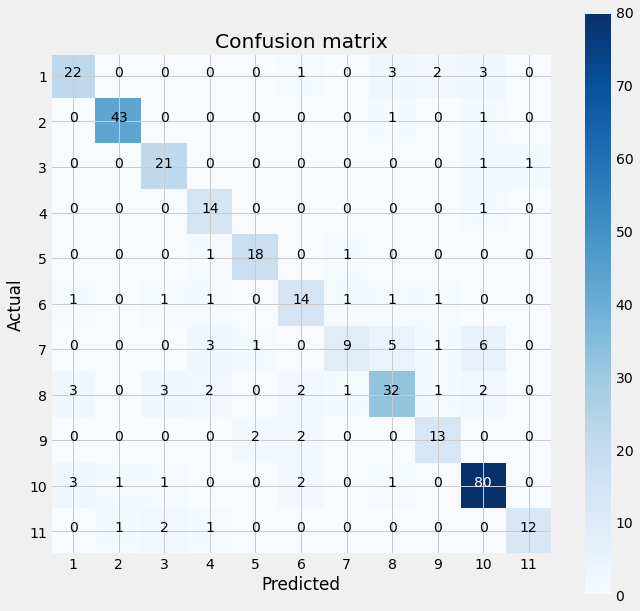

In [60]:
print_model_metrics(gb2_y_preds, gb2_y_score, y2_test)

### XGBoost

In [80]:
xgb2, xgb2_y_preds, xgb2_y_score = build_model(XGBClassifier(objective='multi:softmax'), 
                                            X2_train, X2_test, y2_train, y2_test, decision_function=False)

Total Runtime: 0.5809247493743896 seconds


Accuracy: 0.8208

Micro Precision: 0.8208
Micro Recall: 0.8208
Micro F1: 0.8208

Macro Precision: 0.8165
Macro Recall: 0.8123
Macro F1-score: 0.8060

Weighted Precision: 0.8244
Weighted Recall: 0.8208
Weighted F1-score: 0.8170


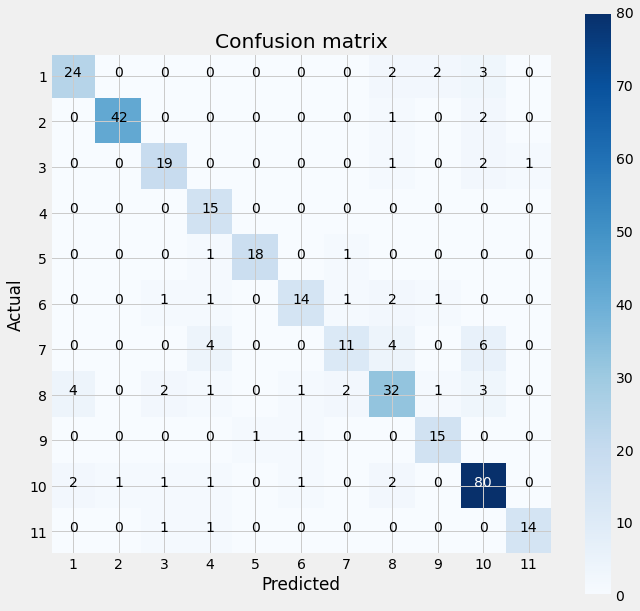

In [81]:
print_model_metrics(xgb2_y_preds, xgb2_y_score, y2_test)

In [134]:
print(f'Training Accuracy: {xgb2.score(X2_train, y2_train)}')
print(f'Test Accuracy: {xgb2.score(X2_test, y2_test)}')

Training Accuracy: 1.0
Test Accuracy: 0.8208092485549133


In [135]:
xgb2.save_model('final_model.model')

**Gridsearch**

In [90]:
xgb2_param_grid = {"min_child_weight": [2, 3, 4],
                  "max_depth": [6, 9, 12],
                  "eta": [.001, .005, .01]
                }

xgb2_gs, xgb2_gs_y_preds, xgb2_gs_y_score = build_model(GridSearchCV(xgb2, param_grid=xgb2_param_grid),
                                                         X2_train, X2_test,
                                                         y2_train, y2_test,
                                                        decision_function=False)

Total Runtime: 88.47410583496094 seconds


Accuracy: 0.75

Micro Precision: 0.75
Micro Recall: 0.75
Micro F1: 0.75

Macro Precision: 0.7654
Macro Recall: 0.7595
Macro F1-score: 0.7489

Weighted Precision: 0.7851
Weighted Recall: 0.7500
Weighted F1-score: 0.7548


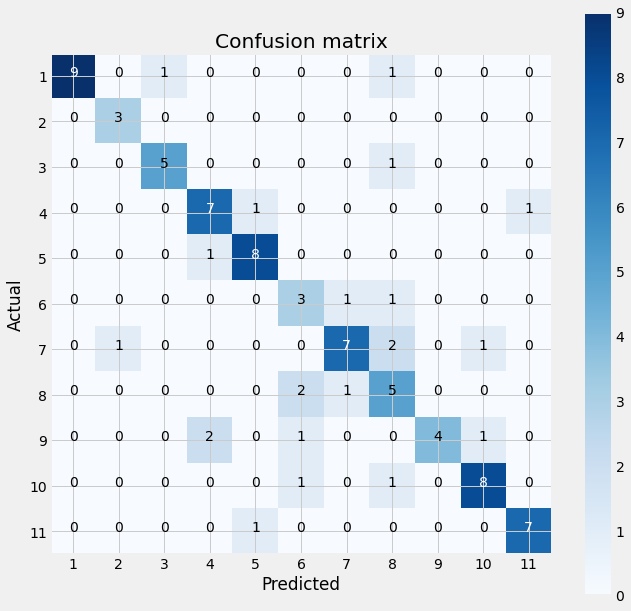

In [91]:
print_model_metrics(xgb_gs_y_preds, xgb_gs_y_score, y_test)

In [92]:
xgb2_gs.best_params_

{'eta': 0.001, 'max_depth': 9, 'min_child_weight': 3}

### Neural Network

In [99]:
# binarize target column

binarizer = LabelBinarizer()
labels = binarizer.fit_transform(y2_train)

In [100]:
labels.shape

(1037, 11)

In [114]:
%reset_selective -f model_1

In [116]:
model_1 = Sequential()
model_1.add(Dense(64, activation='tanh', input_shape=(1037,29)))
model_1.add(Dense(32, activation='tanh'))
model_1.add(Dense(11, activation='softmax'))

model_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [117]:
model_1_results = model_1.fit(X2_train_scaled, labels, epochs=150, batch_size=32, validation_split=0.2)

Epoch 1/150
26/26 [==============================] - 0s 7ms/step - loss: 2.2369 - acc: 0.2376 - val_loss: 2.0638 - val_acc: 0.3942
Epoch 2/150
26/26 [==============================] - 0s 2ms/step - loss: 1.9676 - acc: 0.3884 - val_loss: 1.8293 - val_acc: 0.4135
Epoch 3/150
26/26 [==============================] - 0s 2ms/step - loss: 1.7651 - acc: 0.4089 - val_loss: 1.6277 - val_acc: 0.4904
Epoch 4/150
26/26 [==============================] - 0s 2ms/step - loss: 1.5818 - acc: 0.4717 - val_loss: 1.4534 - val_acc: 0.5337
Epoch 5/150
26/26 [==============================] - 0s 2ms/step - loss: 1.4284 - acc: 0.5271 - val_loss: 1.3073 - val_acc: 0.5673
Epoch 6/150
26/26 [==============================] - 0s 2ms/step - loss: 1.3056 - acc: 0.5814 - val_loss: 1.1970 - val_acc: 0.6202
Epoch 7/150
26/26 [==============================] - 0s 2ms/step - loss: 1.2071 - acc: 0.6140 - val_loss: 1.1052 - val_acc: 0.6154
Epoch 8/150
26/26 [==============================] - 0s 2ms/step - loss: 1.1357 - a

Epoch 58/150
26/26 [==============================] - 0s 1ms/step - loss: 0.5584 - acc: 0.8106 - val_loss: 0.6037 - val_acc: 0.7404
Epoch 59/150
26/26 [==============================] - 0s 1ms/step - loss: 0.5557 - acc: 0.8094 - val_loss: 0.6099 - val_acc: 0.7452
Epoch 60/150
26/26 [==============================] - 0s 1ms/step - loss: 0.5528 - acc: 0.8058 - val_loss: 0.6046 - val_acc: 0.7500
Epoch 61/150
26/26 [==============================] - 0s 2ms/step - loss: 0.5406 - acc: 0.8191 - val_loss: 0.6110 - val_acc: 0.7500
Epoch 62/150
26/26 [==============================] - 0s 2ms/step - loss: 0.5439 - acc: 0.8142 - val_loss: 0.5995 - val_acc: 0.7644
Epoch 63/150
26/26 [==============================] - 0s 1ms/step - loss: 0.5350 - acc: 0.8118 - val_loss: 0.5951 - val_acc: 0.7596
Epoch 64/150
26/26 [==============================] - 0s 1ms/step - loss: 0.5270 - acc: 0.8179 - val_loss: 0.5935 - val_acc: 0.7452
Epoch 65/150
26/26 [==============================] - 0s 1ms/step - loss: 0.

Epoch 120/150
26/26 [==============================] - 0s 1ms/step - loss: 0.4101 - acc: 0.8565 - val_loss: 0.5520 - val_acc: 0.7885
Epoch 121/150
26/26 [==============================] - 0s 1ms/step - loss: 0.4056 - acc: 0.8637 - val_loss: 0.5319 - val_acc: 0.7933
Epoch 122/150
26/26 [==============================] - 0s 1ms/step - loss: 0.3981 - acc: 0.8685 - val_loss: 0.5324 - val_acc: 0.7885
Epoch 123/150
26/26 [==============================] - 0s 1ms/step - loss: 0.4009 - acc: 0.8625 - val_loss: 0.5360 - val_acc: 0.7740
Epoch 124/150
26/26 [==============================] - 0s 1ms/step - loss: 0.4062 - acc: 0.8613 - val_loss: 0.5407 - val_acc: 0.8029
Epoch 125/150
26/26 [==============================] - 0s 1ms/step - loss: 0.3926 - acc: 0.8637 - val_loss: 0.5344 - val_acc: 0.7885
Epoch 126/150
26/26 [==============================] - 0s 1ms/step - loss: 0.4034 - acc: 0.8685 - val_loss: 0.5385 - val_acc: 0.7837
Epoch 127/150
26/26 [==============================] - 0s 1ms/step - 

In [130]:
%reset_selective -f model_2

In [131]:
model_2 = Sequential()
model_2.add(Dense(128, activation='tanh', input_shape=(1037,29)))
#model_2.add(Dense(32, activation='tanh'))
model_2.add(Dense(11, activation='softmax'))

model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [132]:
model_2_results = model_2.fit(X2_train_scaled, labels, epochs=150, batch_size=32, validation_split=0.2)

Epoch 1/150
26/26 [==============================] - 2s 95ms/step - loss: 2.3021 - acc: 0.2123 - val_loss: 2.0716 - val_acc: 0.3221
Epoch 2/150
26/26 [==============================] - 0s 2ms/step - loss: 2.0129 - acc: 0.3595 - val_loss: 1.8218 - val_acc: 0.4615
Epoch 3/150
26/26 [==============================] - 0s 3ms/step - loss: 1.7951 - acc: 0.4222 - val_loss: 1.6240 - val_acc: 0.5000
Epoch 4/150
26/26 [==============================] - 0s 3ms/step - loss: 1.6250 - acc: 0.4487 - val_loss: 1.4714 - val_acc: 0.5288
Epoch 5/150
26/26 [==============================] - 0s 3ms/step - loss: 1.4850 - acc: 0.5042 - val_loss: 1.3606 - val_acc: 0.5529
Epoch 6/150
26/26 [==============================] - 0s 2ms/step - loss: 1.3787 - acc: 0.5344 - val_loss: 1.2668 - val_acc: 0.5913
Epoch 7/150
26/26 [==============================] - 0s 2ms/step - loss: 1.2929 - acc: 0.5802 - val_loss: 1.1956 - val_acc: 0.5962
Epoch 8/150
26/26 [==============================] - 0s 2ms/step - loss: 1.2215 - 

Epoch 58/150
26/26 [==============================] - 0s 2ms/step - loss: 0.6068 - acc: 0.7877 - val_loss: 0.6430 - val_acc: 0.7404
Epoch 59/150
26/26 [==============================] - 0s 1ms/step - loss: 0.6083 - acc: 0.7853 - val_loss: 0.6527 - val_acc: 0.7356
Epoch 60/150
26/26 [==============================] - 0s 1ms/step - loss: 0.6108 - acc: 0.7744 - val_loss: 0.6613 - val_acc: 0.7212
Epoch 61/150
26/26 [==============================] - 0s 1ms/step - loss: 0.6017 - acc: 0.7805 - val_loss: 0.6545 - val_acc: 0.7260
Epoch 62/150
26/26 [==============================] - 0s 1ms/step - loss: 0.6015 - acc: 0.7756 - val_loss: 0.6375 - val_acc: 0.7452
Epoch 63/150
26/26 [==============================] - 0s 1ms/step - loss: 0.5950 - acc: 0.7865 - val_loss: 0.6397 - val_acc: 0.7404
Epoch 64/150
26/26 [==============================] - 0s 1ms/step - loss: 0.5924 - acc: 0.7817 - val_loss: 0.6407 - val_acc: 0.7308
Epoch 65/150
26/26 [==============================] - 0s 1ms/step - loss: 0.

Epoch 120/150
26/26 [==============================] - 0s 1ms/step - loss: 0.5009 - acc: 0.8227 - val_loss: 0.5766 - val_acc: 0.7644
Epoch 121/150
26/26 [==============================] - 0s 1ms/step - loss: 0.4980 - acc: 0.8227 - val_loss: 0.5718 - val_acc: 0.7596
Epoch 122/150
26/26 [==============================] - 0s 2ms/step - loss: 0.4985 - acc: 0.8239 - val_loss: 0.5828 - val_acc: 0.7644
Epoch 123/150
26/26 [==============================] - 0s 2ms/step - loss: 0.4979 - acc: 0.8203 - val_loss: 0.5712 - val_acc: 0.7740
Epoch 124/150
26/26 [==============================] - 0s 2ms/step - loss: 0.5042 - acc: 0.8227 - val_loss: 0.5875 - val_acc: 0.7452
Epoch 125/150
26/26 [==============================] - 0s 1ms/step - loss: 0.5001 - acc: 0.8263 - val_loss: 0.5884 - val_acc: 0.7500
Epoch 126/150
26/26 [==============================] - 0s 1ms/step - loss: 0.4973 - acc: 0.8215 - val_loss: 0.5713 - val_acc: 0.7644
Epoch 127/150
26/26 [==============================] - 0s 1ms/step - 

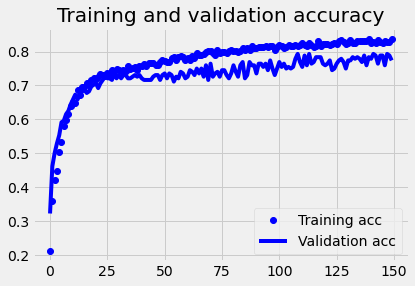

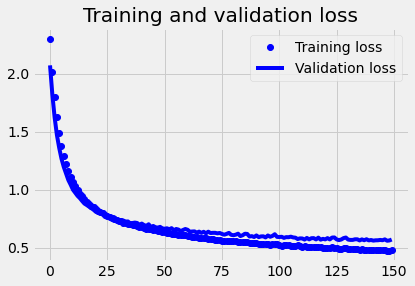

In [133]:
acc = model_2_results.history['acc']
val_acc = model_2_results.history['val_acc']
loss = model_2_results.history['loss']
val_loss = model_2_results.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Final Model will be the XGBoost model with 82.08% test accuracy

In [1]:
# list of good teams and bad teams (top and bottom 8)
good_2015 = ['GSW', 'SAS', 'CLE', 'TOR', 'OKC', 'LAC', 'ATL', 'BOS']
bad_2015 = ['PHI', 'LAL', 'BRK', 'PHO', 'MIN', 'NOP', 'NYK', 'SAC']

good_2016 = ['GSW', 'SAS', 'HOU', 'BOS', 'CLE', 'LAC', 'TOR', 'UTA']
bad_2016 = ['BRK', 'PHO', 'LAL', 'PHI', 'ORL', 'NYK', 'MIN', 'SAC']

good_2017 = ['HOU', 'TOR', 'GSW', 'BOS', 'PHI', 'CLE', 'POR', 'IND']
bad_2017 = ['PHO', 'MEM', 'DAL', 'ATL', 'ORL', 'SAC', 'CHI', 'BRK']

good_2018 = ['MIL', 'TOR', 'GSW', 'DEN', 'HOU', 'POR', 'PHI','UTA']
bad_2018 = ['NYK', 'PHO', 'CLE', 'CHI', 'ATL', 'WAS', 'NOP', 'MEM']

good_2019 = ['MIL', 'TOR', 'LAL', 'LAC', 'BOS', 'DEN', 'IND', 'HOU']
bad_2019 = ['GSW', 'MIN', 'CLE', 'DET', 'ATL', 'NYK', 'CHI', 'CHA']

good_2020 = ['UTA', 'PHI', 'PHO', 'LAC', 'MIL', 'BRK', 'LAL', 'DEN']
bad_2020 = ['MIN', 'DET', 'ORL', 'HOU', 'WAS', 'CLE', 'TOR', 'OKC']

In [5]:
xgboost = XGBClassifier()
xgboost.load_model('final_model.model')

In [ ]:
xgboost.